In [20]:
# import 구문 정렬
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import (LeakyReLU, Activation, Conv1D, MaxPooling1D, Flatten, Dense, 
                                     BatchNormalization, ReLU, GlobalAveragePooling1D, Dropout, 
                                     GlobalMaxPooling1D)
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting settings
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # minus 표시


In [21]:
# 드라이브에서 train, test 데이터셋 불러오기

# arff.loadarff() 함수는 두개의 값을 반환. (데이터 numpy array, meta 데이터 객체)
data_train, meta_train = arff.loadarff('./FordA/FordA_TRAIN.arff')
data_test, meta_test = arff.loadarff('./FordA/FordA_TEST.arff')

# 데이터를 DataFrame 형식으로 변환
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

In [22]:
# train, test 데이터셋 정보
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 13.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 5.0+ MB
None


##### - train : 3601개 데이터, 501개 열 (target 1개 포함)
##### - test : 1320개 데이터, 501개 열 (target 1개 포함)
##### - 데이터 500개 열 값은 float64 type, 마지막 target열은 object type

In [23]:
# target 값은 [b'-1', b'1'] byte 형식으로 인코딩 되어 있음
print(train_df.target.unique())

# target 값을 일반 문자열로 디코딩 한 후, int 형으로 변환
train_df['target'] = train_df['target'].apply(lambda x: int(x.decode()))
test_df['target'] = test_df['target'].apply(lambda x: int(x.decode()))

# target 값 -1을 0으로 변환
train_df['target'] = train_df['target'].replace(-1, 0)
test_df['target'] = test_df['target'].replace(-1, 0)

print(train_df.target.unique()) # 변환 후 target 값 출력

[b'-1' b'1']
[0 1]


In [24]:
# 열 이름 변경 'att' -> 'sen' (센서 값)
train_df.columns = train_df.columns.str.replace('att', 's')
test_df.columns = test_df.columns.str.replace('att', 's')

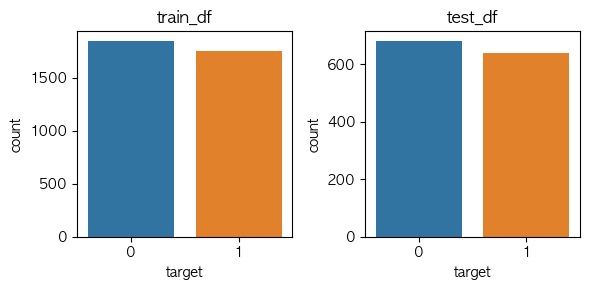

train_df_0_class : 1846
train_df_1_class : 1755
test_df_0_class : 681
test_df_1_class : 639


In [25]:
# 데이터셋의 target값 비중 불균형이 있는지 확인
#   -> sns.countplot: 범주형 데이터의 분포, sns.histplot: 연속형 데이터의 분포
fig, axs = plt.subplots(1,2, figsize=(6,3))
sns.countplot(data=train_df, x='target', ax=axs[0])
sns.countplot(data=test_df, x='target', ax=axs[1])
axs[0].set_title('train_df')
axs[1].set_title('test_df')
fig.tight_layout()
plt.show()

print('train_df_0_class :', len(train_df.loc[train_df.target==0]))
print('train_df_1_class :', len(train_df.loc[train_df.target==1]))
print('test_df_0_class :', len(test_df.loc[test_df.target==0]))
print('test_df_1_class :', len(test_df.loc[test_df.target==1]))

##### - 데이터셋의 target값 비중의 균형은 맞춰져 있다.

In [26]:
# train_df 구조 확인 (3601 rows × 501 columns)
train_df

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,0
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,1
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,0
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,1


In [27]:
# train_df의 features(각 센서 값) 요약
train_df.describe()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,...,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,-0.016708,-0.015270,-0.013605,-0.011943,-0.009966,-0.007062,-0.003495,0.000568,0.005354,0.010032,...,0.006895,0.004053,0.000929,-0.001922,-0.003369,-0.003237,-0.001820,0.000031,0.001395,0.487365
std,1.058455,1.051904,1.044560,1.042573,1.046933,1.052829,1.055439,1.054305,1.050424,1.044120,...,1.040632,1.040826,1.036657,1.028358,1.018719,1.011871,1.012367,1.020914,1.032490,0.499910
min,-3.933454,-3.656912,-3.479467,-3.595350,-3.773891,-3.914729,-3.855301,-4.497360,-4.552591,-4.000282,...,-4.073011,-4.014450,-3.817036,-3.574256,-3.746353,-3.680805,-3.904569,-4.221550,-4.076032,0.000000
25%,-0.685693,-0.699526,-0.688302,-0.709732,-0.694991,-0.691035,-0.690316,-0.701244,-0.675094,-0.687749,...,-0.690143,-0.688232,-0.677701,-0.674282,-0.655946,-0.657258,-0.664392,-0.659578,-0.675838,0.000000
50%,-0.007573,-0.003044,-0.003066,0.008598,0.001042,0.000280,-0.011988,-0.026672,-0.002031,0.010602,...,0.012348,0.003914,0.005957,-0.002728,-0.010841,-0.008002,-0.004802,-0.013723,-0.003186,0.000000
75%,0.660360,0.674898,0.683698,0.679474,0.697530,0.688802,0.721442,0.705021,0.692256,0.689118,...,0.714817,0.707357,0.692837,0.666434,0.668463,0.671536,0.677346,0.684048,0.682921,1.000000
max,3.503936,3.369278,3.498286,3.493830,3.293318,3.605585,3.895870,3.741035,3.630933,3.579176,...,3.522197,3.842693,3.916653,3.670118,3.567879,3.471847,3.798079,3.863325,4.349744,1.000000


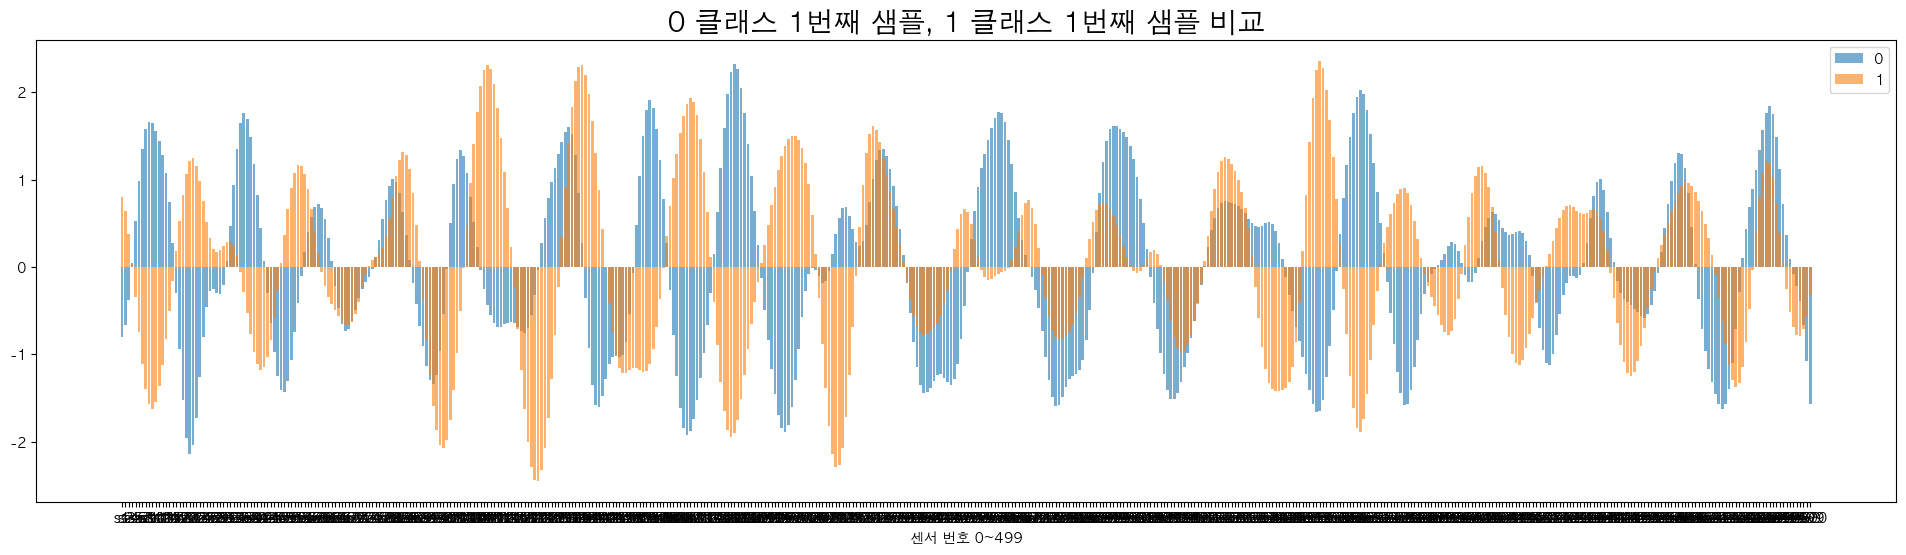

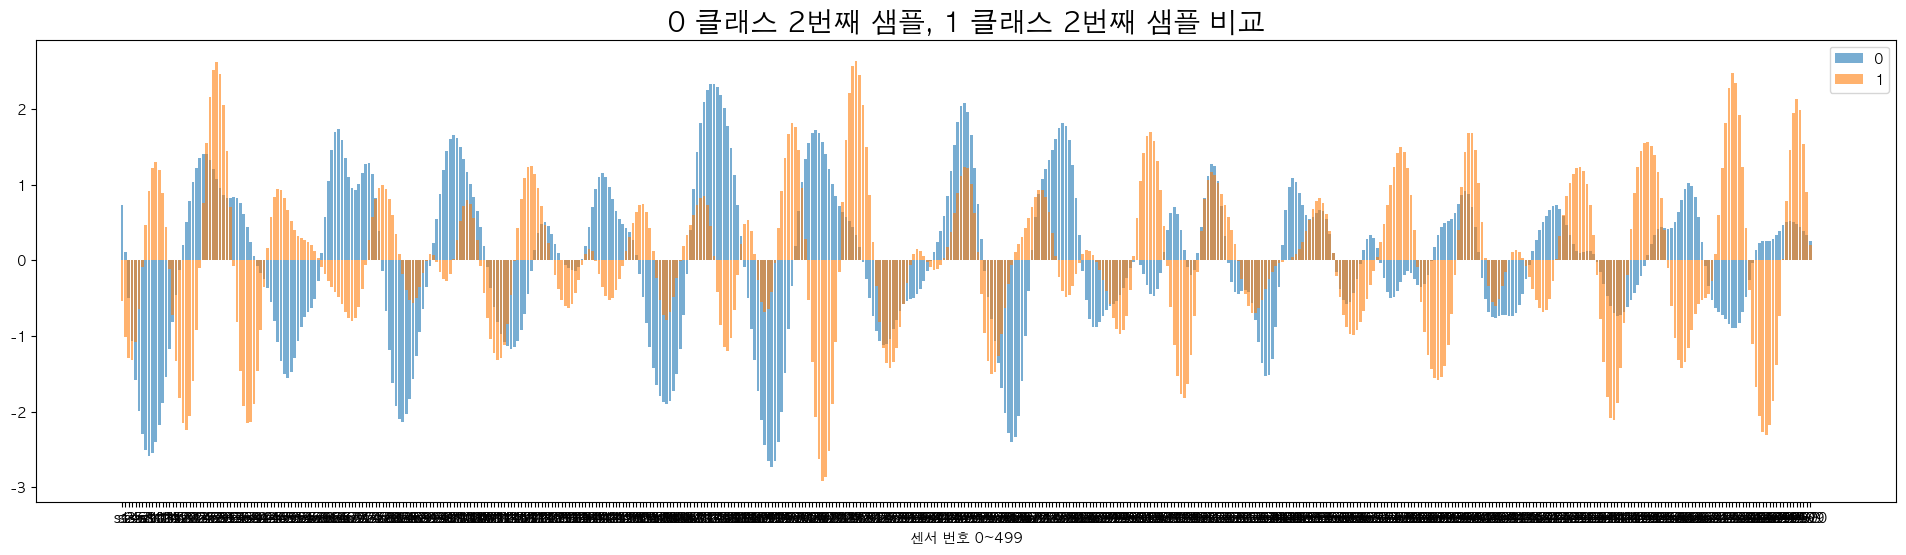

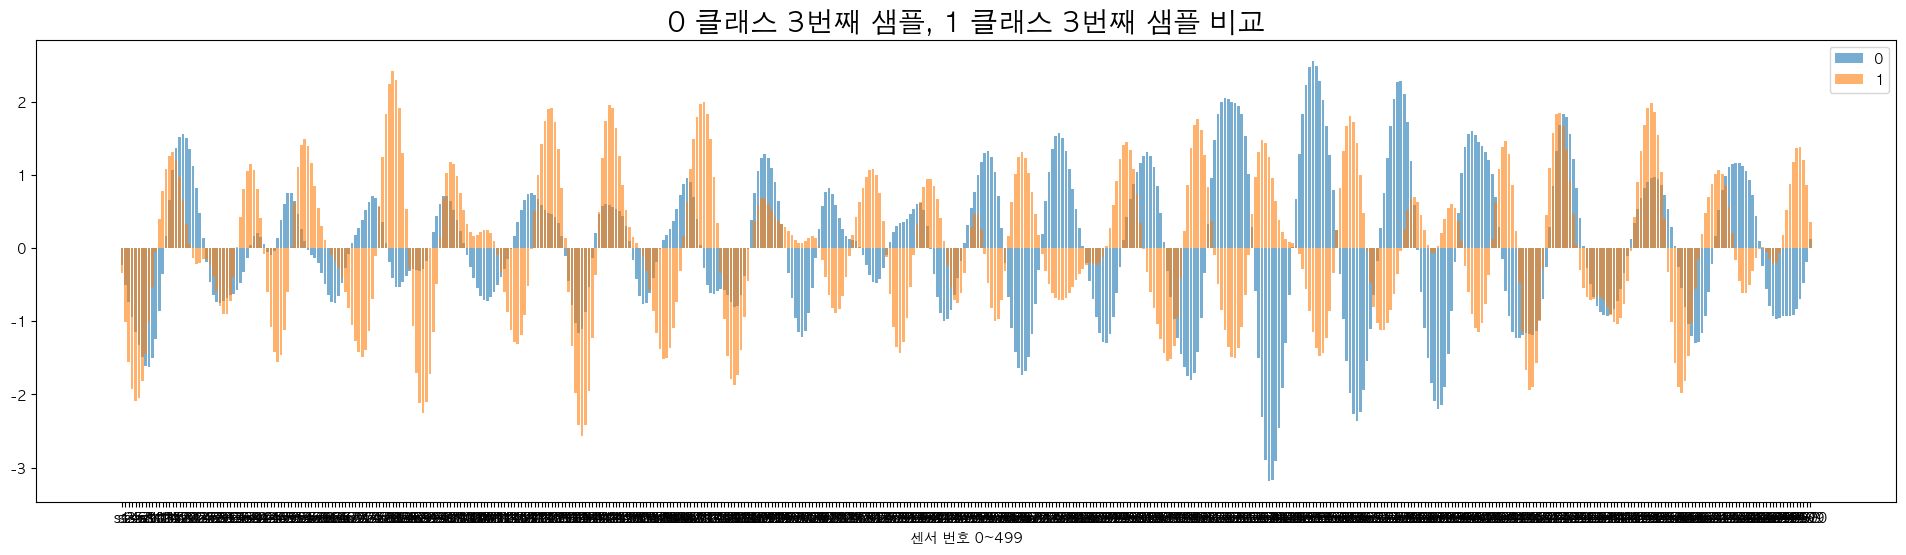

In [28]:
## 0과 1 클래스의 각 샘플 센서값 분포 비교

# 클래스가 0, 1인 인덱스 추출
idx_0 = train_df.loc[train_df.target==0].index
idx_1 = train_df.loc[train_df.target==1].index

# 가로: 센서 번호, 세로: 센서 값
for i in range(3): # 비교 하고 싶은 개수 설정 (3개 비교)
    plt.figure(figsize=(24,6))
    plt.bar(train_df.columns[:-1], train_df.iloc[idx_0[i], :-1], label='0', alpha=0.6)
    plt.bar(train_df.columns[:-1], train_df.iloc[idx_1[i], :-1], label='1', alpha=0.6)
    plt.title(f'0 클래스 {i+1}번째 샘플, 1 클래스 {i+1}번째 샘플 비교', fontsize=20)
    plt.xlabel('센서 번호 0~499')
    plt.legend()
    plt.show()

##### 낱개로 비교해서 보면 클래스별 차이가 있으나, 전체적으로 보면 경향이 안보임
##### -> 클래스별 전체 평균을 낼 필요 있음

In [29]:
# 각 센서의 클래스별(0,1) 평균 값
s_means = train_df.groupby(by='target').mean()

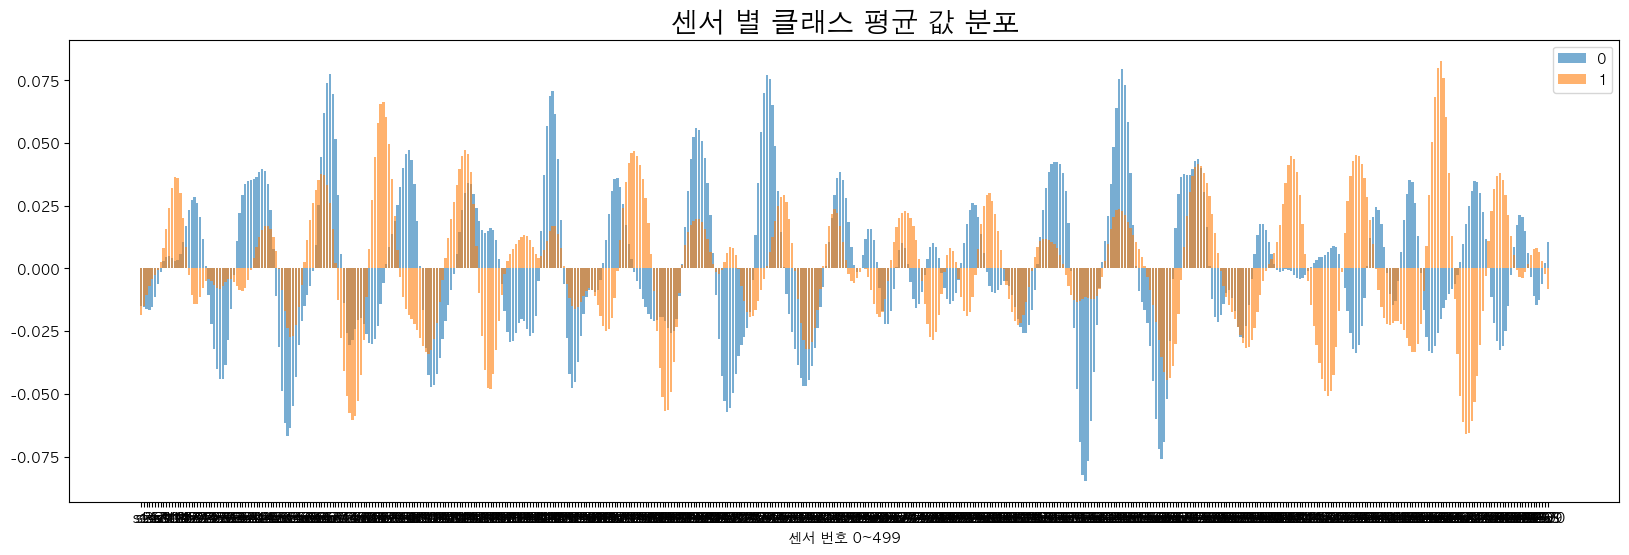

In [30]:
# 가로: 센서 번호, 세로: 센서 별 클래스 평균 값
#   -> 센서 별로 2개의 클래스(0, 1)
plt.figure(figsize=(20,6))
plt.bar(s_means.columns, s_means.iloc[0,:], alpha=0.6, label='0')
plt.bar(s_means.columns, s_means.iloc[1,:], alpha=0.6, label='1')
plt.title('센서 별 클래스 평균 값 분포', fontsize=20)
plt.xlabel('센서 번호 0~499')
plt.legend()

plt.show()


##### - 센서별 평균 값이 -0.1 ~ 0.1 사이에 위치하고 있어 스케일링은 불필요 할것으로 보임
##### - 센서 후반부 클래스에 따라 센서값이 명확하게 갈림. -> 후반부 센서만 학습 시켜볼 필요 있음

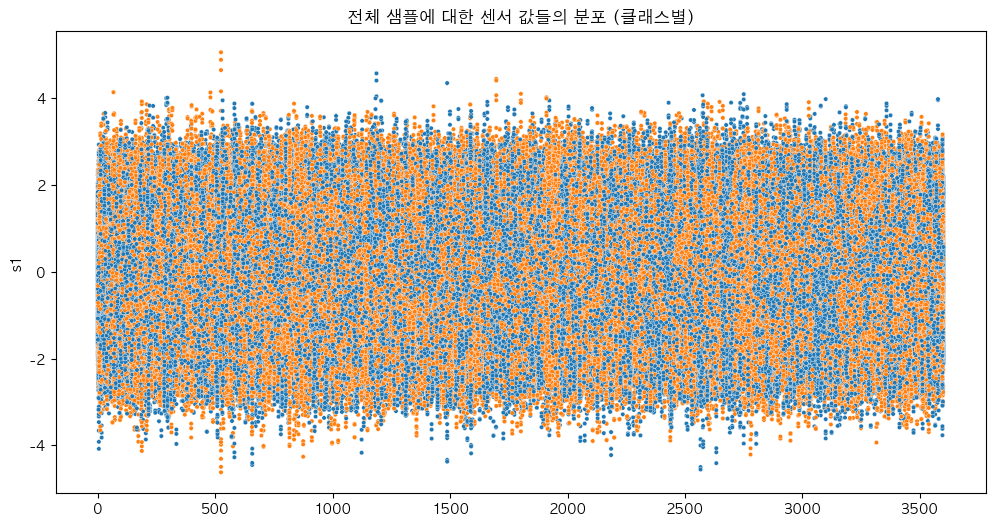

In [31]:
# 가로: 샘플, 세로: 모든 센서들의 값 (클래스별)

plt.figure(figsize=(12,6))
plt.title('전체 샘플에 대한 센서 값들의 분포 (클래스별)')
for i in range(train_df.shape[1]-1): #traget열 제외 모든 센서값 인덱싱
    sns.scatterplot(data=train_df, x=train_df.index, y=train_df.iloc[:,i], s=10,
                    hue='target', legend=False)

##### - 샘플 클래스별 센서값들의 분포는 차이가 없다.
##### - 흐름이 눈에 안들어 온다. 클래스별 평균값으로 다시 보자.

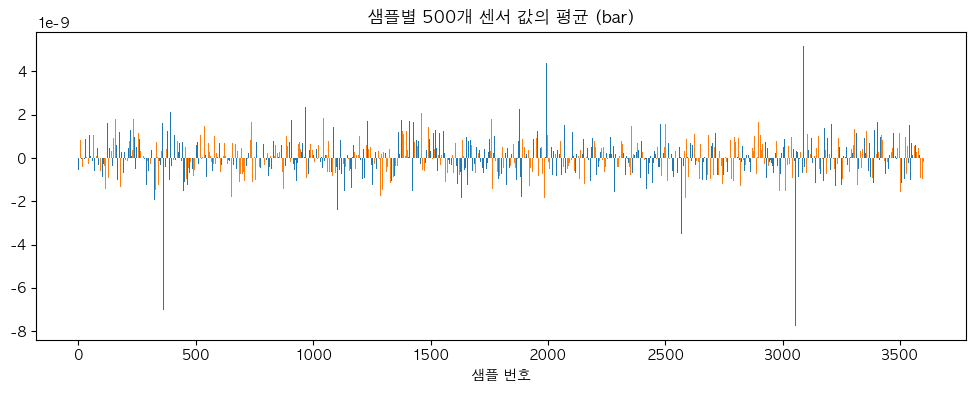

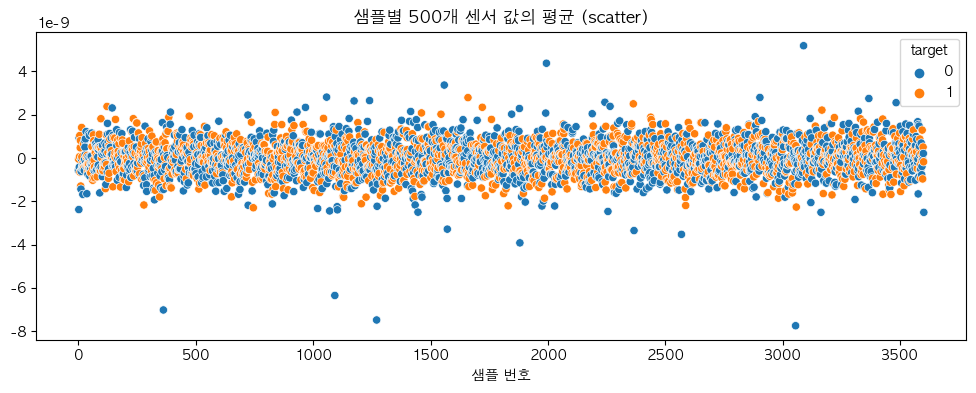

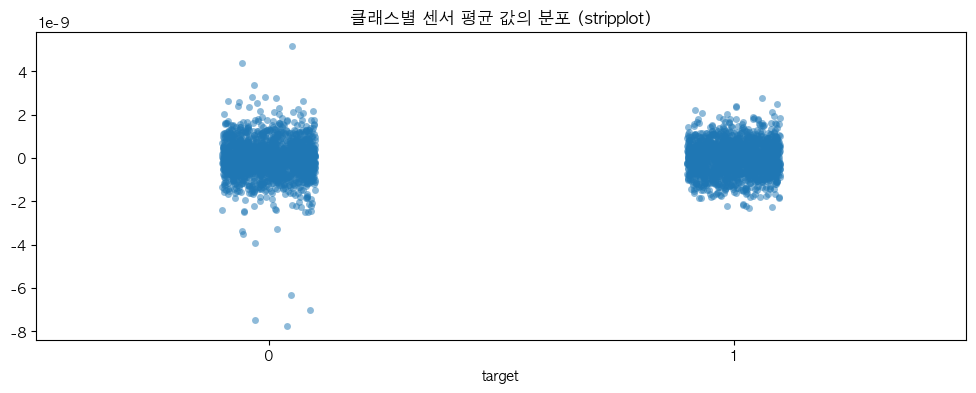

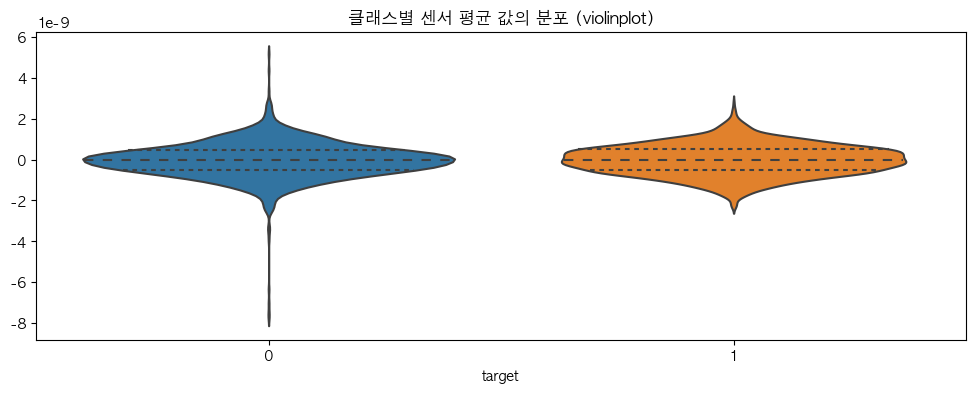

In [32]:
# 가로: 샘플 번호, 세로: 500개 센서 값 평균

# 클래스별 데이터프레임 생성
train_0 = train_df.loc[train_df.target == 0]
train_1 = train_df.loc[train_df.target == 1]

# 샘플별 500개 센서 값의 평균 (bar)
plt.figure(figsize=(12,4))
plt.bar(train_0.index, train_0.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.title('샘플별 500개 센서 값의 평균 (bar)')
plt.xlabel('샘플 번호')

# 샘플별 500개 센서 값의 평균 (scatter)
plt.figure(figsize=(12,4))
sns.scatterplot(x=train_df.index, y=train_df.iloc[:,:-1].mean(axis=1),
                hue=train_df.target)
plt.title('샘플별 500개 센서 값의 평균 (scatter)')
plt.xlabel('샘플 번호')

# 클래스별 센서 평균 값의 분포 (stripplot)
plt.figure(figsize=(12,4))
sns.stripplot(data=train_df, x=train_df.target, y=train_df.iloc[:, :-1].mean(axis=1),
              jitter=True, marker='o', alpha=0.5)
plt.title('클래스별 센서 평균 값의 분포 (stripplot)')
plt.xlabel('target')

# 클래스별 센서 평균 값의 분포 (violinplot)
plt.figure(figsize=(12,4))
sns.violinplot(x=train_df.target, y=train_df.iloc[:, :-1].mean(axis=1), inner="quart")
plt.title('클래스별 센서 평균 값의 분포 (violinplot)')
plt.xlabel('target')

plt.show()


##### - 0클래스에서 튀는값이 있다. ->  제거 전/후 학습 결과 비교 필요
##### - 시계열 데이터로 의미는 없어보인다. (RNN으로 학습 시켜볼 필요는 있음)

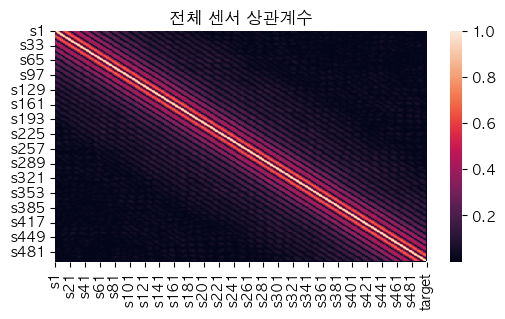

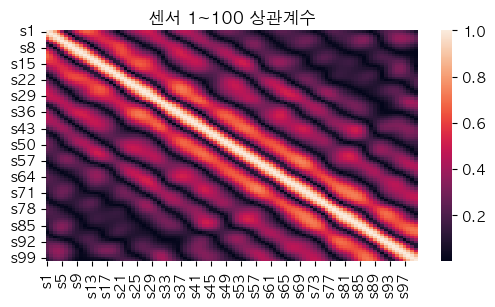

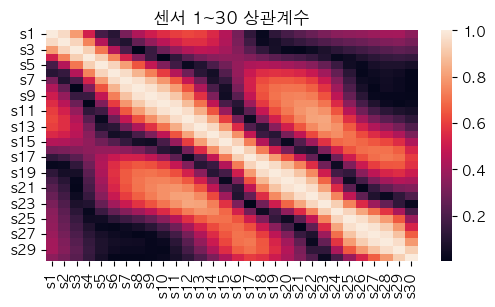

In [33]:
# target과 각 센서 값의 상관관계 분석

# 전체 센서 상관계수
plt.figure(figsize=(6,3))
plt.title('전체 센서 상관계수')
train_corr = abs(train_df.corr())
sns.heatmap(train_corr)

# 센서 1~100 상관계수
plt.figure(figsize=(6,3))
plt.title('센서 1~100 상관계수')
corr_100 = abs(train_df.iloc[:100, :100].corr())
sns.heatmap(corr_100)

# 센서 1~30 상관계수
plt.figure(figsize=(6,3))
plt.title('센서 1~30 상관계수')
corr_30 = abs(train_df.iloc[:30, :30].corr())
sns.heatmap(corr_30, xticklabels=1)

fig.tight_layout()
plt.show()

##### - 인접한 3개 센서와 밀접한 연관성이 있다. (-> CNN)
#####   -> CNN 학습 특징 추출시 kernel_size를 3~4로 하면 효과적이다?

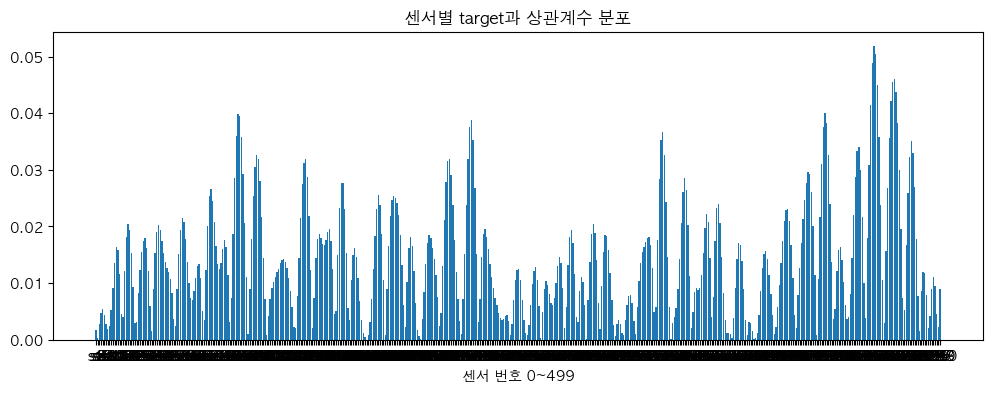

target과 상관관계 상위 센서
s461    0.051789
s462    0.050375
s460    0.048899
s473    0.045961
s472    0.045462
s463    0.044951
s474    0.043726
s471    0.042066
s459    0.041494
s432    0.040031
Name: target, dtype: float64


In [34]:
# 센서별 target과 상관계수 분포 (target에 영향을 주는 센서 확인)
#   -> 가로: 센서, 세로: target과 상관계수 값
plt.figure(figsize=(12,4))
plt.title('센서별 target과 상관계수 분포')
plt.xlabel('센서 번호 0~499')
plt.bar(train_df.columns[:-1], train_corr.target[:-1])

fig.tight_layout()
plt.show()

# target과 센서간의 상관계수를 내림차순 정리
#   -> target에 영향을 주는 센서 확인
print('target과 상관관계 상위 센서')
print(train_corr.target.sort_values(ascending=False).head(11).drop('target',axis=0))

##### - 앞에서 본것 처럼 후반부가 상관관계가 높다. (s430 이후)
##### - 상관관계 상위 센서로만 학습해서 결과를 볼 필요 있음

In [37]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_df) 
# y_pred = predictor.predict(test_df)
# # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율
# accuracy = (test_df.target == y_pred).mean() 
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

In [38]:
# leaderboard = predictor.leaderboard(test_df)
# leaderboard

In [39]:
# train, test 데이터셋 라벨 분리 (x, y)
# AutoML에서는 라벨열을 지정해서 라벨을 인식했지만, 개별 ML에서는 라벨을 분리해서 학습
x_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
x_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3601, 500) (3601,) (1320, 500) (1320,)


In [40]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier
# # 학습 및 예측 모델 4가지 리스트
# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0),
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)

# # 캔버스 3개 만들기 (혼동행렬 / Feat.Imp. 상위 10항목 / Feat.Imp. 전체 분포)
# fig, axs = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))
# fig2, axs2 = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))
# fig3, axs3 = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))

# fig.suptitle('[각 모델의 혼동 행렬]', fontsize=16)
# fig2.suptitle('[각 모델의 Feature importances 상위10 센서]', fontsize=16)
# fig3.suptitle('[각 모델의 Feature importances 센서별 분포]', fontsize=16)

# # 전체 모델 학습 후 정확도, 혼동행렬, Feature Importance 출력하기
# for i in range(len(model)): # 모델 리스트 크기만큼 반복
#     model[i].fit(x_train, y_train) # 모델 한개씩 불러와서 학습
#     y_pred = model[i].predict(x_test) # 각 모델 예측값 변수에 할당
#     accuracy = accuracy_score(y_test, y_pred) # 각 모델 정확도 변수에 할당
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%') # 각 모델 정확도 출력
    
#     # 각 모델의 혼동 행렬을 히트맵으로 그리기
#     conf_mat = confusion_matrix(y_test, y_pred) # 혼동 행렬 만들기 (2,2)
#     sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axs[i])
#     axs[i].set_title(model_list[i])
#     axs[i].set_ylabel('Actual')
#     axs[i].set_xlabel('Predicted')

#     # Feature importances 상위10 항목 구하기
#     imp_df = pd.DataFrame(model[i].feature_importances_) # ndarray 형태를 DataFrame 형태로 바꾸기
#     imp_df.rename(columns={0:'imp'}, inplace=True) # 열 이름 변경
#     imp_df.index = 's' + imp_df.index.astype(str) # 인덱스명 변경 ('s'추가하여 str으로)
#     imp_df_sort = imp_df.sort_values(by='imp', ascending=False) # 내림차순 정렬

#     axs2[i].bar(imp_df_sort.head(10).index, imp_df_sort.head(10).iloc[:, 0]) #top10 출력
#     axs2[i].set_title(model_list[i])
#     axs2[i].tick_params(axis='x', rotation=90)
#     axs2[i].set_xlabel('Sensor_no.')
#     axs2[i].set_ylabel('Importances')
    
#     # Feature importances 센서별 분포
#     axs3[i].bar(imp_df.index, imp_df.imp.values)
#     axs3[i].set_title(model_list[i])
#     axs3[i].set_xlabel('Sensor_no.')
#     axs3[i].set_ylabel('Importances')
        
# fig.tight_layout()
# fig2.tight_layout()
# fig3.tight_layout()

# plt.show()

##### 후반부 센서의 Feature importances 값이 높게 나타나지 않음
##### -> target과 상관관계가 높은 센서라고 해서 Feature importances 값이 높은 것은 아니다.

##### CNN 하이퍼 파라미터 엑셀 참고

In [41]:
## logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 로지스틱 회귀 모델 생성 및 학습
lr_model = LogisticRegression(max_iter=1000)  # 최대 반복 횟수를 설정
lr_model.fit(x_train, y_train)

# 테스트 데이터에서 예측 수행
y_pred_lr = lr_model.predict(x_test)

# 정확도 계산 및 출력
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr_percentage = round(accuracy_lr * 100, 2)
print(f'Logistic Regression accuracy: {accuracy_lr_percentage}%')


Logistic Regression accuracy: 49.55%


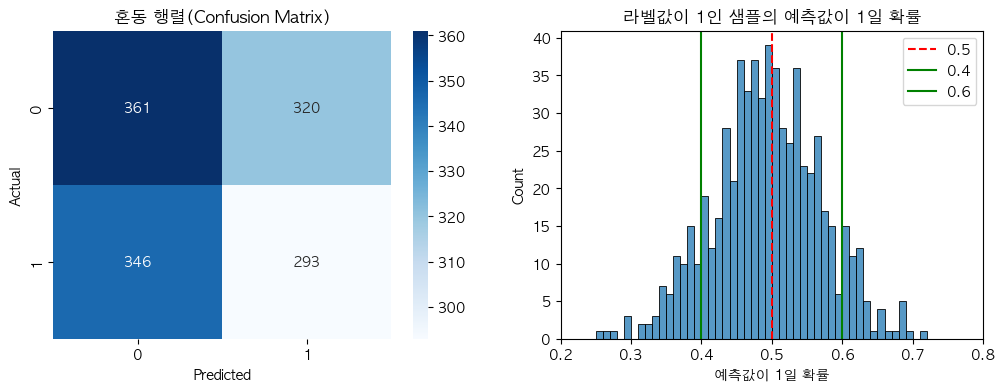

In [172]:
target1_proba = y_pred_proba[y_test==1,:]
low_limit = 0.4
high_limit = 0.6

fig, axs = plt.subplots(1, 2, figsize=(12,4))

# 혼동 행렬(Confusion Matrix)
confusion = confusion_matrix(y_test, y_pred_lr)

# 히트맵으로 시각화
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'], ax=axs[0])
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
axs[0].set_title('혼동 행렬(Confusion Matrix)')

sns.histplot(target1_proba[:, 1], binwidth=0.01, ax=axs[1])
axs[1].axvline(0.5, color='red', linestyle='--', label='0.5')
axs[1].axvline(low_limit, color='green', linestyle='-', label=low_limit)
axs[1].axvline(high_limit, color='green', linestyle='-', label=high_limit)
axs[1].set_xticks(np.arange(0.2, 0.8, 0.1))
axs[1].set_xlabel('예측값이 1일 확률')
axs[1].set_title('라벨값이 1인 샘플의 예측값이 1일 확률')
axs[1].legend()

plt.show()



In [173]:
in_limit = np.sum((target1_proba[:, 1] >= 0.4) & (target1_proba[:, 1] <= 0.6))
in_limit_rate = round(in_limit / len(target1_proba)*100, 1)
print(f'{low_limit}~{high_limit} 사이에 포함되는 값의 비율 : {in_limit_rate}%')
print(in_limit)
print(len(target1_proba))

0.4~0.6 사이에 포함되는 값의 비율 : 80.0%
511
639


##### Logistic Regression 모델로 학습이 안됨
#####  - 예측 정확도 : 49.55%
#####  - 혼동 행렬에서 1을 1로 맞힐 확률이 오답일 확률보다 작음
#####  - 라벨값이 1인 샘플의 예측값이 1일 확률이 0.4~0.6 사이에 80%가 몰려있음 (511/639)

Epoch 1/3


2023-08-16 18:01:33.635069: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 31s 678ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.6066 - val_sparse_categorical_accuracy: 0.6241
Epoch 2/3
45/45 [==============================] - 30s 667ms/step - loss: 0.5683 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.6356 - val_sparse_categorical_accuracy: 0.6200
Epoch 3/3
45/45 [==============================] - 29s 652ms/step - loss: 0.5311 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.6234 - val_sparse_categorical_accuracy: 0.6560


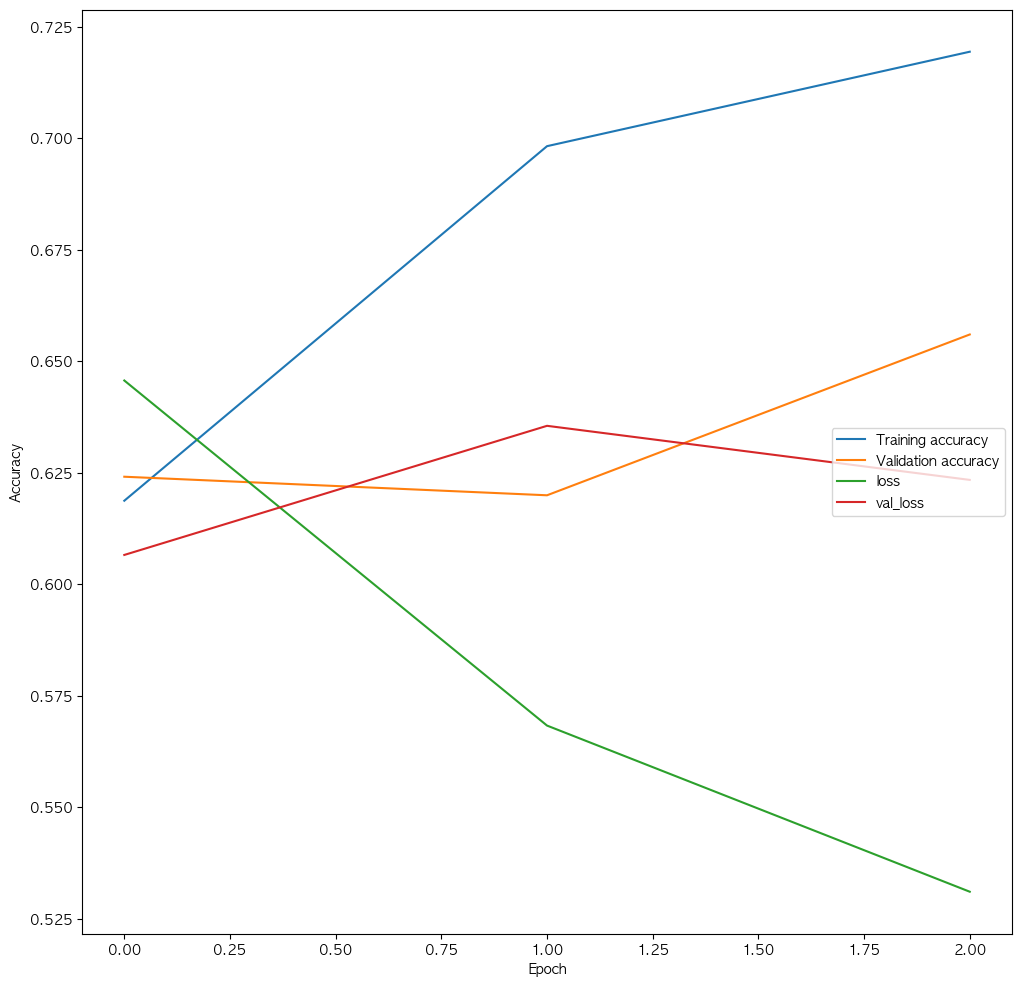

In [ ]:
# # RNN, CNN 학습을 위해 x_train 차원 변경
# x_train_exp = np.expand_dims(x_train, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가
# x_test_exp = np.expand_dims(x_test, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가

# # RNN(LSTM) 학습
# from tensorflow.keras.layers import LSTM

# def make_rnn_model():
#   model = Sequential()
#   model.add(LSTM(units=256, return_sequences=True,input_shape=(500, 1)))
#   model.add(Flatten())
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(2, activation='softmax'))
#   return model

# rnn_model = make_rnn_model()

# rnn_model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['sparse_categorical_accuracy'])

# callbacks_rnn = [
#     ModelCheckpoint('rnn_best_model.h5', save_best_only=True,
#                     monitor='val_sparse_categorical_accuracy', mode='max'),
#     ]

# history_rnn = rnn_model.fit(x_train_exp, y_train,
#                             batch_size=64, validation_split=0.2, epochs=3,
#                             callbacks=callbacks_rnn, verbose=1)

# # Plotting the accuracy and validation accuracy
# plt.figure(figsize=(12, 12))
# plt.plot(history_rnn.history['sparse_categorical_accuracy'], label='Training accuracy')
# plt.plot(history_rnn.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
# plt.plot(history_rnn.history['loss'], label='loss')
# plt.plot(history_rnn.history['val_loss'], label='val_loss')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='right')
# plt.show()

In [ ]:
# from tensorflow.keras.layers import LSTM

# def make_rnn_model():
#   model = Sequential()
#   model.add(LSTM(units=256, return_sequences=True, input_shape=(500, 1)))
#   model.add(Flatten())
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(2, activation='softmax'))
#   return model

# rnn_model = make_rnn_model()

# rnn_model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['sparse_categorical_accuracy'])

# callbacks = [
#     ModelCheckpoint('rnn_best_model.h5', save_best_only=True,
#                     monitor='val_sparse_categorical_accuracy', mode='max'),
#     ]

# history = rnn_model.fit(x_train_exp, y_train,
#                             batch_size=64, validation_split=0.2, epochs=3,
#                             callbacks=callbacks, verbose=1)

# # # 학습 중 정확도 베스트 정확도
# max_train_accuracy = max(history.history['sparse_categorical_accuracy'])
# max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
# max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
# max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1

# # 학습 중 손실 베스트
# min_train_loss = min(history.history['loss'])
# min_val_loss = min(history.history['val_loss'])
# min_tra_loss_idx = np.argmin(history.history['loss']) + 1
# min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# print(f'Max train acc : {max_tra_acc_idx}_epoch_{max_train_accuracy}')
# print(f'Max val acc: {max_tra_acc_idx}_epoch_{max_val_accuracy}', '\n')
# print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
# print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}', '\n')

# #  정확도 베스트 모델로 평가 (베스트 모델은 callbacks에 설정 됨)
# model = load_model('rnn_best_model.h5')
# scores = model.evaluate(x_test_exp, y_test)
# print('test acrr ', scores[1])
# print('test loss ', scores[0], '\n')

# # 정확도, 손실 그래프
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
# plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# plt.show()

# # 모델 구조 / 파라미터 개수 확인
# model.summary()

##### - 시계열 연관성 없음 

In [ ]:
##################################
# 튀는값 제거 후 재학습
##################################

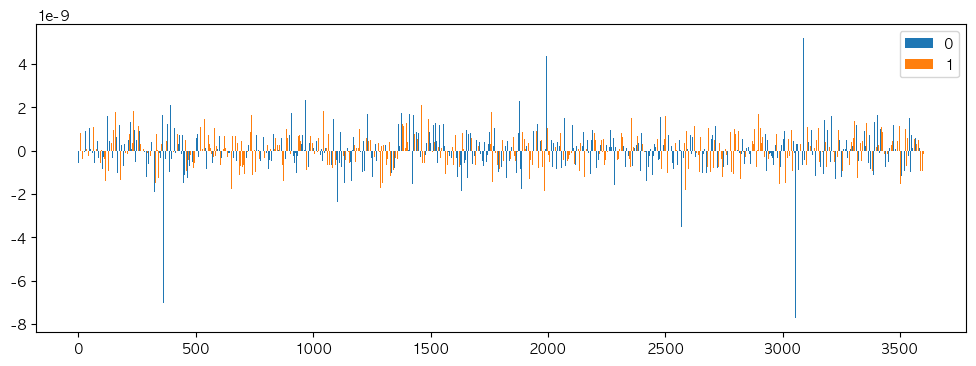

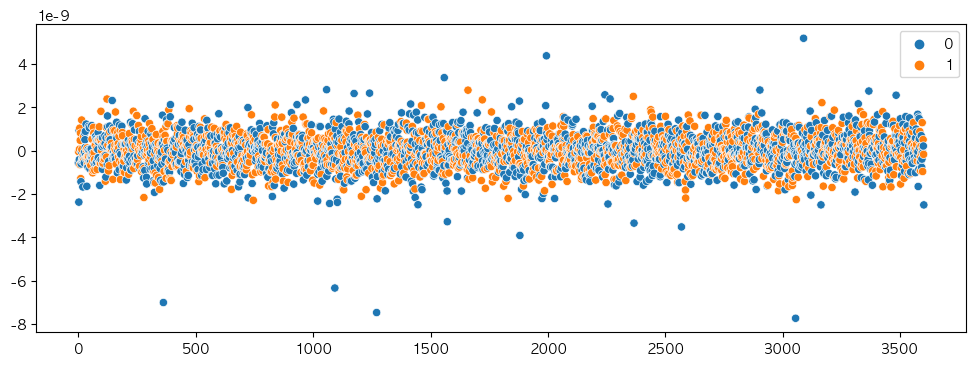

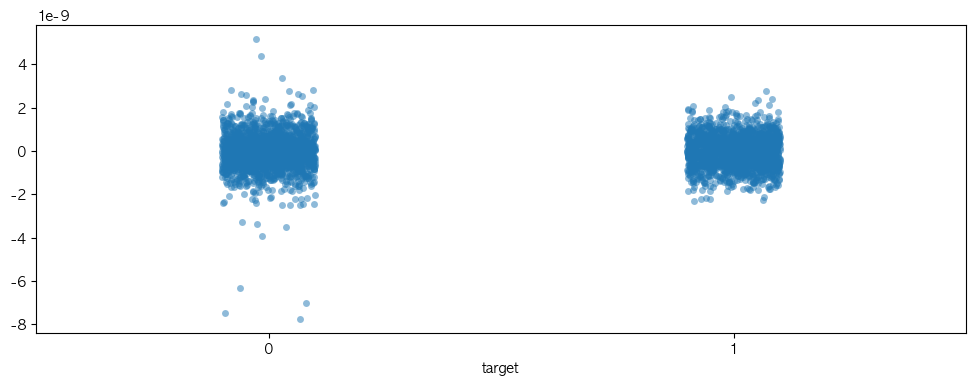

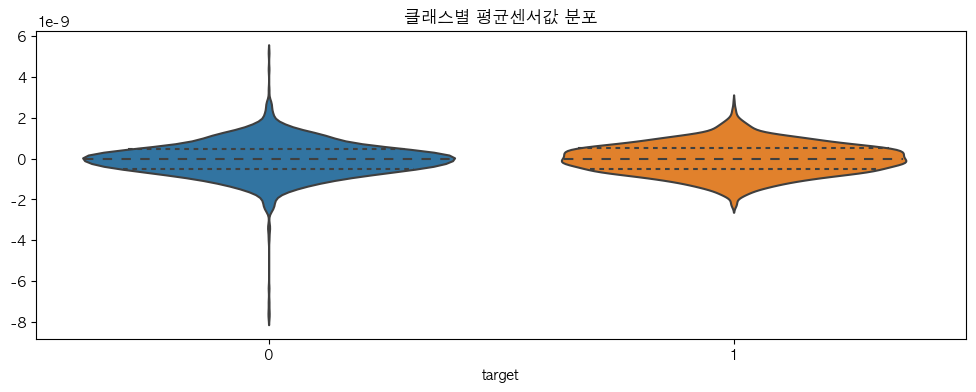

In [ ]:
# 센서값 전체를 평균값 하나로 압축시켜서 시각화
plt.figure(figsize=(12,4))
plt.bar(train_0.index, train_0.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.legend()

# 센서값 전체를 평균값 하나로 압축시켜서 시각화
plt.figure(figsize=(12,4))
sns.scatterplot(x=train_df.index, y=train_df.iloc[:,:-1].mean(axis=1), hue=train_df.target)
plt.legend()
plt.show()

# 주어진 코드를 stripplot으로 변경
plt.figure(figsize=(12,4))
sns.stripplot(data=train_df, x=train_df.target, y=train_df.iloc[:, :-1].mean(axis=1), jitter=True, marker='o', alpha=0.5)

# 위 그래프를 violinplt 으로
plt.figure(figsize=(12,4))
sns.violinplot(x=train_df.target, y=train_df.iloc[:, :-1].mean(axis=1), inner="quart")

plt.title('클래스별 평균센서값 분포')
plt.xlabel('target')
plt.show()

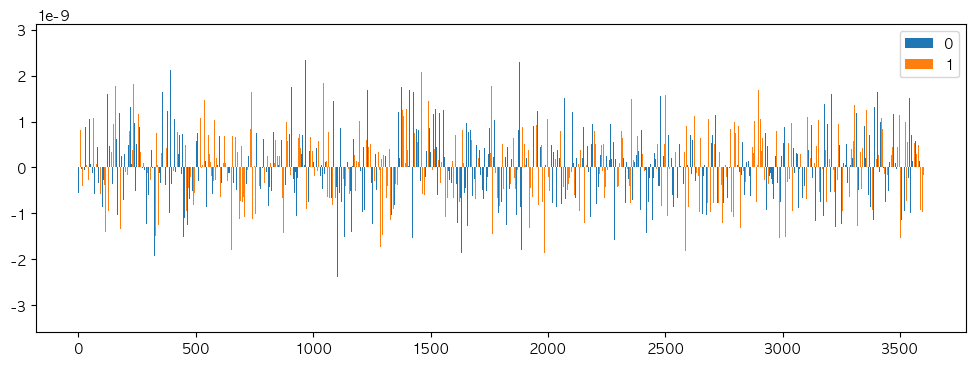

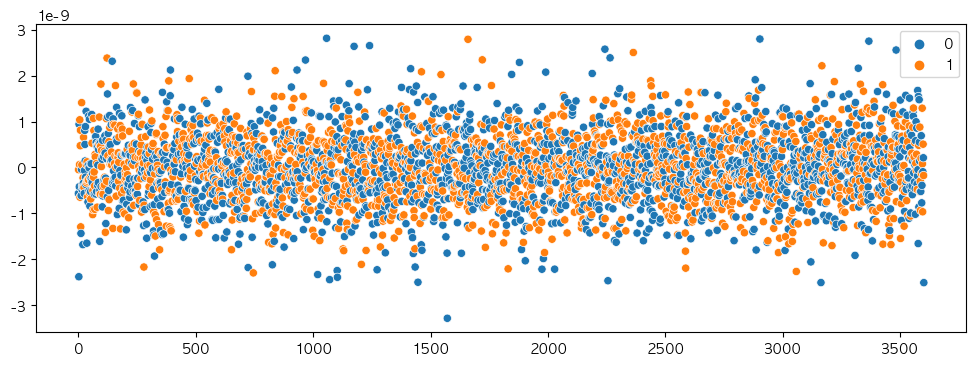

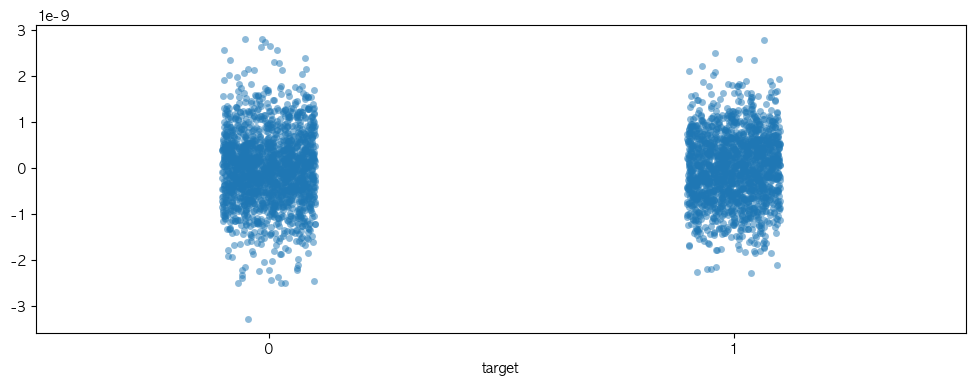

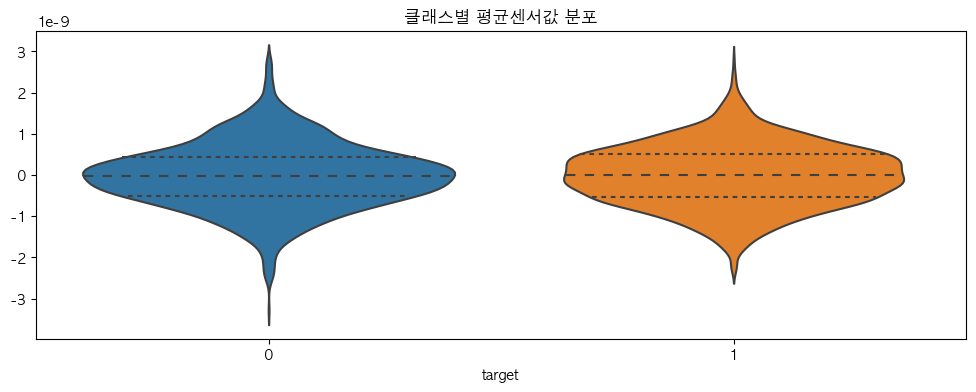

In [ ]:
### 위 3개 그래프를 튀는값 날린 후 재 시각화

# 센서 평균값이 높은 샘플(인덱스) 추출, 제거
drop_idx = abs(train_0.iloc[:, :-1].mean(axis=1)).sort_values(ascending=False).head(10).index
train_0_drop = train_0.drop(drop_idx)

# 센서 평균값이 높은 인덱스 제거 후 그래프 다시 그리기
plt.figure(figsize=(12,4))
plt.bar(train_0_drop.index, train_0_drop.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.legend()
plt.show()

# 센서값 전체를 평균값 하나로 압축시켜서 시각화
plt.figure(figsize=(12,4))
sns.scatterplot(x=train_df.index, y=train_df.drop(drop_idx).iloc[:,:-1].mean(axis=1), hue=train_df.target)
plt.legend()
plt.show()

# 주어진 코드를 stripplot으로 변경
plt.figure(figsize=(12,4))
sns.stripplot(data=train_df, x=train_df.target, y=train_df.drop(drop_idx).iloc[:, :-1].mean(axis=1), jitter=True, marker='o', alpha=0.5)

# 위 그래프를 violinplt 으로
plt.figure(figsize=(12,4))
sns.violinplot(x=train_df.target, y=train_df.drop(drop_idx).iloc[:, :-1].mean(axis=1), inner="quart")

plt.title('클래스별 평균센서값 분포')
plt.xlabel('target')
plt.show()

In [ ]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_df_drop) 
# predictor = TabularPredictor(label='target').fit(train_df_drop) 
# y_pred = predictor.predict(test_df)
# accuracy = (test_df.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

##### - 센서 평균값이 튀는 샘플을 제거 했을 때 ML 정확도는 크게 변화 없음

In [ ]:
# x_train_drop = train_df_drop.iloc[:, :-1]
# y_train_drop = train_df_drop.iloc[:, -1]
# x_test = test_df.iloc[:, :-1]
# y_test = test_df.iloc[:, -1]

# print(x_train_drop.shape)
# print(y_train_drop.shape)
# print(x_test.shape)
# print(y_test.shape)

In [ ]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train_drop, y_train_drop)
#     y_pred = model[i].predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


##### - 센서 평균값이 튀는 샘플을 제거 했을 때 ML 정확도는 크게 변화 없음
##### - 센서 평균값이 튀는 샘플을 제거 했을 때 CNN 성능 떨어짐 (근접 센서와 연관 있는데 중간중간 이빠져서)

In [ ]:
##################################
# 후반부만 학습시켜보기 (s403 ~)
##################################

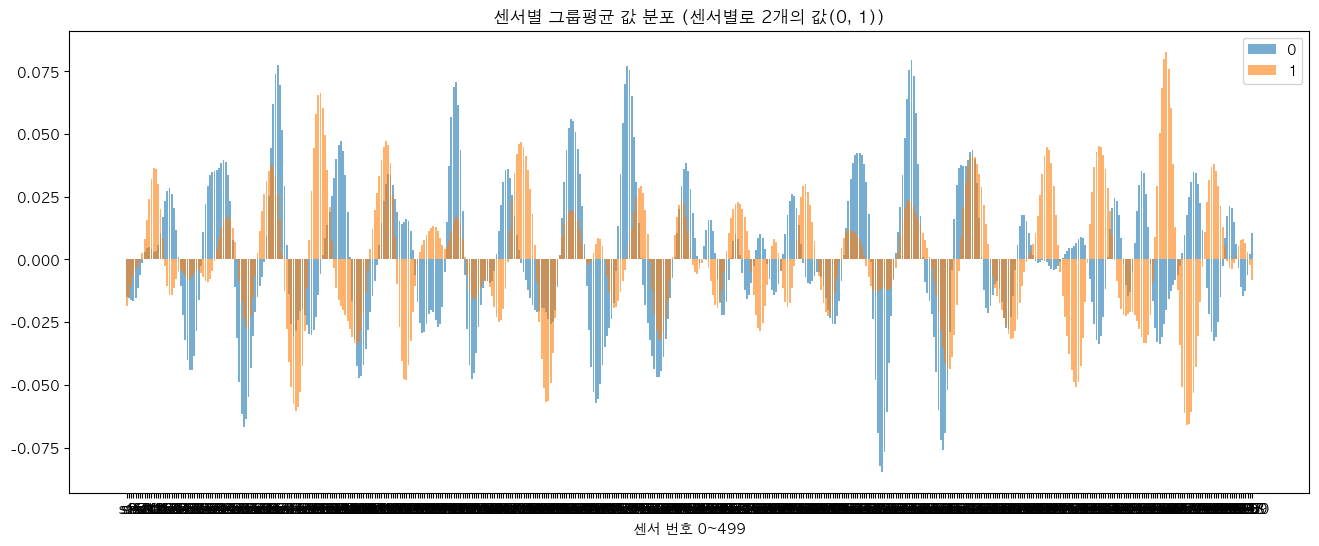

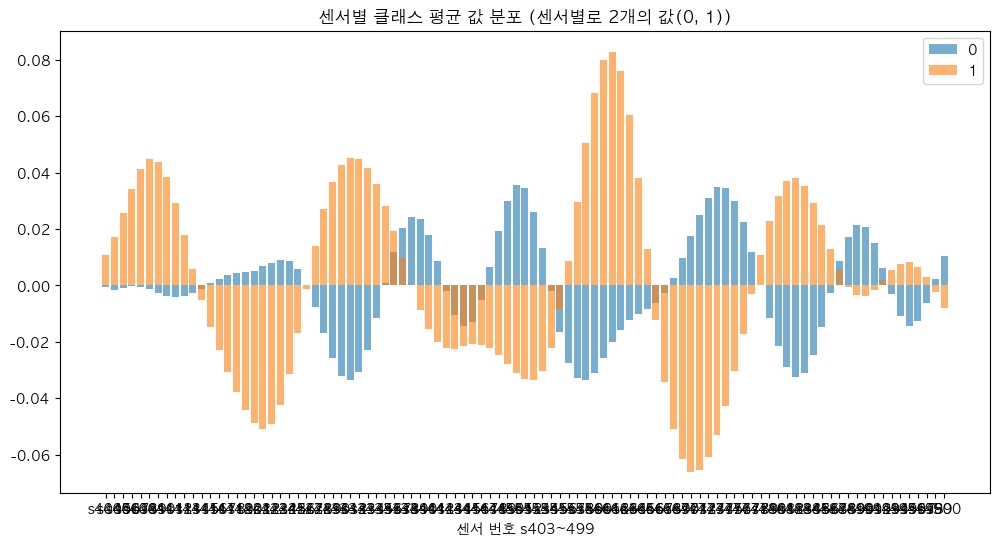

In [ ]:
# 가로:센서, 세로:그룹별(0,1) 모든 제품들 센서값의 평균(scatter)
#   -> 센서별 그룹평균 값 분포 (센서별로 2개의 값(0, 1))
plt.figure(figsize=(16,6))
plt.bar(s_means.columns, s_means.iloc[0,:], alpha=0.6, label='0')
plt.bar(s_means.columns, s_means.iloc[1,:], alpha=0.6, label='1')
plt.title('센서별 그룹평균 값 분포 (센서별로 2개의 값(0, 1))')
plt.xlabel('센서 번호 0~499')
plt.legend()

# 후반부만 표시
plt.figure(figsize=(12,6))
col_i = 403
plt.bar(s_means.columns[col_i:], s_means.iloc[0,col_i:], alpha=0.6, label='0')
plt.bar(s_means.columns[col_i:], s_means.iloc[1,col_i:], alpha=0.6, label='1')
plt.title('센서별 클래스 평균 값 분포 (센서별로 2개의 값(0, 1))')
plt.xlabel('센서 번호 s403~499')
plt.legend()

plt.show()

In [ ]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_403) 
# y_pred = predictor.predict(test_403)
# accuracy = (test_403.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

##### - s403 이후만 가지고 학습할 경우, 오히려 데이터 부족으로 학습이 잘 안됨

In [ ]:
# x_train_403 = train_403.iloc[:, :-1]
# y_train_403 = train_403.iloc[:, -1]
# x_test_403 = test_403.iloc[:, :-1]
# y_test_403 = test_403.iloc[:, -1]

# print(x_train_403.shape)
# print(y_train_403.shape)
# print(x_test_403.shape)
# print(y_test_403.shape)

In [ ]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train_403, y_train_403)
#     y_pred = model[i].predict(x_test_403)
#     accuracy = accuracy_score(y_test_403, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


##### - s403 이후만 가지고 학습할 경우, ML, CNN 모두 학습 잘 안됨
#####   -> 오히려 데이터 부족으로 학습이 잘 안되는 듯

In [ ]:
##################################
# target과 상관계수 상위 센서로만 학습시켜보기 (490 -> 470 -> 450 -> 400 -> 300)
##################################
# 정렬 시키면 안됨. 센서 순서가 흐트러짐
# 낮은 인덱스를 찾아서 드롭 시키기

In [ ]:
train_corr = abs(train_df.corr())
corr_target = train_corr.target.sort_values(ascending=False).tail(10)
print(corr_target.index)
train_corr = train_df.drop(corr_target.index, axis=1)
test_corr = test_df.drop(corr_target.index, axis=1)
train_corr

Index(['s160', 's391', 's264', 's377', 's2', 's291', 's341', 's193', 's390',
       's161'],
      dtype='object')


,s1,s3,s4,s5,s6,s7,s8,s9,s10,s11,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
0,-0.797172,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,1.552290,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,-1.545709,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,-2.409010,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,-1.246560,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,1.250755,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,0
3597,0.041994,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,0.185007,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,1
3598,-0.570054,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,2.590779,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,0
3599,2.006732,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,-0.418453,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,1


In [ ]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_corr) 
# y_pred = predictor.predict(test_corr)
# accuracy = (test_corr.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

In [ ]:
# x_train = train_corr.iloc[:, :-1]
# y_train = train_corr.iloc[:, -1]
# x_test = test_corr.iloc[:, :-1]
# y_test = test_corr.iloc[:, -1]

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [ ]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train, y_train)
#     y_pred = model[i].predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


##### - target과 상관계수 낮은 feature들은 삭제하고 학습 시켰을 경우... 효과 없음

##### - logistic regression은 효과 없다.

In [ ]:
##################################
# 데이터 정규화 시켜서 학습
##################################

In [ ]:
# # 정규화
# from sklearn.preprocessing import StandardScaler
# stder = StandardScaler()
# stder.fit(x_train)
# x_train_t = stder.transform(x_train)
# x_train_t

NameError: name 'x_train_t' is not defined

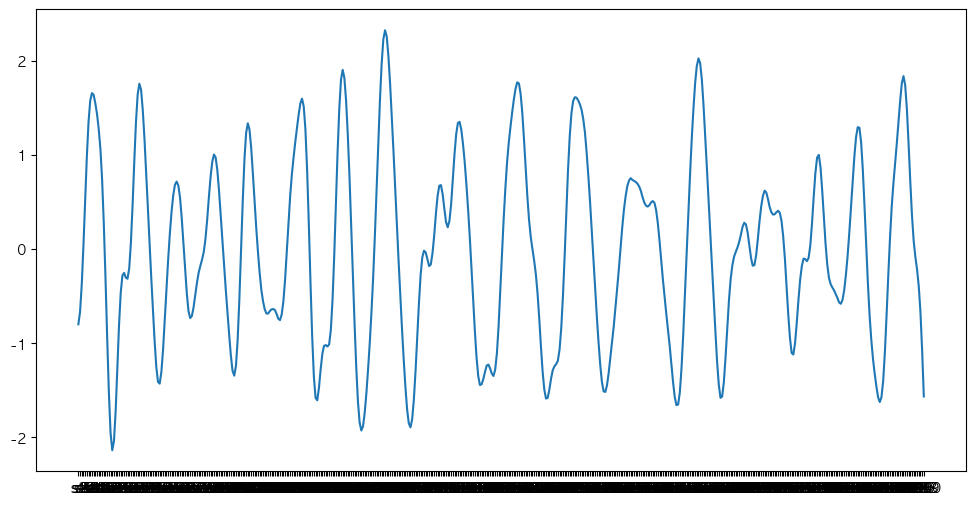

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(x_train.columns, x_train.iloc[0,:])
plt.plot(x_train.columns, x_train_t[0])

In [ ]:
# -----------------------------------------------------------------------
# # 정규화 안했을 떄
# <class 'xgboost.sklearn.XGBClassifier'>_acc : 77.05%
# <class 'lightgbm.sklearn.LGBMClassifier'>_acc : 78.56%
# <class 'catboost.core.CatBoostClassifier'>_acc : 84.55%
# <class 'sklearn.ensemble._forest.RandomForestClassifier'>_acc : 73.33%
# # 정규화 했을 떄
# <class 'xgboost.sklearn.XGBClassifier'>_acc : 76.89%
# <class 'lightgbm.sklearn.LGBMClassifier'>_acc : 77.8%
# <class 'catboost.core.CatBoostClassifier'>_acc : 83.86%
# <class 'sklearn.ensemble._forest.RandomForestClassifier'>_acc : 73.79%

# cnn은 학습률 전/후 비슷함
# Max train acc : 353_epoch_0.9857639074325562
# Max val acc: 353_epoch_0.9736477136611938 
# test acrr  0.9681817889213562
# test loss  0.0936470702290535 
# -----------------------------------------------------------------------

### 1. 머신러닝 학습 결과 (AutoML, 대표 4개)
### 2. 딥러닝 학습 결과 (CNN, RNN)
### 3. 데이터 전처리 다시
### 4. 머신러닝 재학습 (AutoML, 대표 4개)
[원본 트레인셋]
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8469696969696969
XGBClassifier_acc : 77.05%
LGBMClassifier_acc : 78.56%
CatBoostClassifier_acc : 84.55%
RandomForestClassifier_acc : 76.06%

[0클래스 튀는 값 상위 20개 제거 후] -> 비슷, 좋아지지는 않음
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.818939393939394
XGBClassifier_acc : 78.33%
LGBMClassifier_acc : 79.02%
CatBoostClassifier_acc : 84.62%
RandomForestClassifier_acc : 73.56%

[상위 10개 제거 후] -> 비슷, 좋아지지는 않음
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8325757575757575
XGBClassifier_acc : 77.27%
LGBMClassifier_acc : 79.47%
CatBoostClassifier_acc : 83.79%
RandomForestClassifier_acc : 74.02%

[s403 이후만 학습] -> 과소적합 (데이터 부족때문인듯)
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.825
XGBClassifier_acc : 73.79%
LGBMClassifier_acc : 72.27%
CatBoostClassifier_acc : 74.24%
RandomForestClassifier_acc : 71.14%

[corr_490] -> 약간 떨어짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8393939393939394
XGBClassifier_acc : 77.05%
LGBMClassifier_acc : 78.11%
CatBoostClassifier_acc : 83.48%
RandomForestClassifier_acc : 74.24%

[corr_470] -> 비슷하거나 약간 낮음. 베스트모델은 약간 더 좋아짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8575757575757575
XGBClassifier_acc : 76.82%
LGBMClassifier_acc : 78.48%
CatBoostClassifier_acc : 83.41%
RandomForestClassifier_acc : 74.09%

[corr_450] -> 약간 떨어짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8462121212121212
XGBClassifier_acc : 75.76%
LGBMClassifier_acc : 78.11%
CatBoostClassifier_acc : 83.86%
RandomForestClassifier_acc : 73.03%


### 5. 딥러닝 재학습 (CNN)
[원본 트레인셋]
Max train acc : 388_epoch_0.9864583611488342
Max val acc: 388_epoch_0.9791955351829529 
test acrr  0.9712121486663818
test loss  0.09361912310123444 


[0 클래스 튀는 샘플 행 상위 30~100개 제거 후] - 제거 전과 비슷함
- 0클래스가 91개 많아서 100개 제거해도 균형은 맞음

[튀는 샘플 행 상위 20개 제거 후] - 제거 전과 비슷함
Max train acc : 352_epoch_0.98591548204422
Max val acc: 352_epoch_0.9774965047836304 
test acrr  0.9628787636756897
test loss  0.10508657246828079

[상위 10개 제거 후] -> 제거 전과 비슷하나 val acc는 최고기록. 배치사이즈 변경해도 더 나아지지 않으나 배치사이즈가 16일때 과적합이 가장 안됨
Max train acc : 399_epoch_0.9851694703102112
Max val acc: 399_epoch_0.9816642999649048 
test acrr  0.9689394235610962
test loss  0.10294175893068314 

[상위 5개 제거 후] - 제거 전과 비슷함
Max train acc : 324_epoch_0.9885257482528687
Max val acc: 324_epoch_0.980555534362793 
test acrr  0.9643939137458801
test loss  0.09963967651128769 

[s403 열 이후만 학습] -> 학습 잘 안되고 과적합 
test acrr  0.8984848260879517
test loss  0.2471424639225006 

--- 정렬하는 동안 모양이 흐트러짐 : 정렬하지 않고 다시 ---

[corr_490] -> 약간 떨어짐..(중간중간 이빠져서?) 과적합은 없음
Max train acc : 384_epoch_0.9750000238418579
Max val acc: 384_epoch_0.9653259515762329 
test acrr  0.9515151381492615
test loss  0.129542276263237 

[corr_470] -> 학습 안됨 
Max train acc : 331_epoch_0.9284722208976746
Max val acc: 331_epoch_0.919556200504303 
test acrr  0.9037878513336182
test loss  0.23713327944278717 

[corr_495] -> 후반부 과적합
Max train acc : 394_epoch_0.9854166507720947
Max val acc: 394_epoch_0.9750346541404724 
test acrr  0.9621211886405945
test loss  0.11294251680374146 

### 6. 베스트모델 파이토치로 재구현
## ** 뒷단에서 기술 쓰는거보단 앞단에서 데이터를 잘 분석하고, 가공하는 과정이 중요하다.

In [ ]:
### cnn 파이토치로 구현
### 클러스터링 방식으로? 몇개 그룹으로 나눠야 가장 성능이 좋은지... 궁금...k-means 알고리즘 -> k-means보다 DBSCAN 이 좋아보이는듯?
### --> 8월9일 녹방 4:42 부터 참고

In [ ]:
# # CNN 학습 및 예측 결과

# # CNN 학습을 위해 데이터 shape 변환
# x_train_exp = np.expand_dims(x_train, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가
# x_test_exp = np.expand_dims(x_test, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가

# # 하이퍼파라미터 설정
# epoch = 400 # 학습 반복 횟수
# act = 'LeakyReLU' # 활성화 함수
# opt = 'adam' # optimizer
# filter = 32 # Conv1D Layer의 filter수
# batch = 32 # batch size
# val_rate = 0.2 # 검증데이터 비율 20%
# kernel = 3 # filter의 kernel size

# # 모델 정의(구조)

# def make_cnn_model():
#     model = Sequential()

#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,padding='same',
#                      input_shape=(500, 1)))
#     model.add(BatchNormalization()) # batch 데이터의 분포를 정규화

#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,padding='same'))
#     model.add(BatchNormalization()) # batch 데이터의 분포를 정규화

#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,padding='same'))
#     model.add(BatchNormalization()) # batch 데이터의 분포를 정규화

#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(2, activation='softmax'))
    
#     return model

# cnn_model = make_cnn_model() # 모델 초기화

# epochs = epoch
# cnn_model.compile(optimizer=opt,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['sparse_categorical_accuracy'])

# callbacks = [
#     ModelCheckpoint('best_model.h5', save_best_only=True,
#                     monitor='val_sparse_categorical_accuracy', mode='max')
#                     ]

# history = cnn_model.fit(x_train_exp, y_train,
#                         batch_size=batch, validation_split=val_rate,
#                         epochs=epochs, callbacks=callbacks)


# # # 학습 중 정확도 베스트 정확도
# max_train_accuracy = max(history.history['sparse_categorical_accuracy'])
# max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
# max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
# max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1

# # 학습 중 손실 베스트
# min_train_loss = min(history.history['loss'])
# min_val_loss = min(history.history['val_loss'])
# min_tra_loss_idx = np.argmin(history.history['loss']) + 1
# min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# print(f'Max train acc : {max_tra_acc_idx}_epoch_{max_train_accuracy}')
# print(f'Max val acc: {max_tra_acc_idx}_epoch_{max_val_accuracy}', '\n')
# print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
# print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}', '\n')

# #  정확도 베스트 모델로 평가 (베스트 모델은 callbacks에 설정 됨)
# model = load_model('best_model.h5')
# scores = model.evaluate(x_test_exp, y_test)
# print('test acrr ', scores[1])
# print('test loss ', scores[0], '\n')
# # print(f'{max_val_accuracy} {min_val_loss} {scores[1]} {scores[0]} ')

# # 정확도, 손실 그래프
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
# plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title(f'layer_{layer}, filter_{filter}, batch_{batch}, kernel_{kernel}, {act},\
#  {opt}, dataStd_{dataStand}, batchNor_{batchNormal}, val_{val_rate}, epoch_{epoch}')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.show()

# # 모델 구조 / 파라미터 개수 확인
# model.summary()


Epoch 1/400
90/90 [==============================] - 2s 14ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.8391 - val_sparse_categorical_accuracy: 0.4743
Epoch 2/400
90/90 [==============================] - 1s 13ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.7858 - val_loss: 1.2597 - val_sparse_categorical_accuracy: 0.4743
Epoch 3/400
90/90 [==============================] - 1s 15ms/step - loss: 0.4117 - sparse_categorical_accuracy: 0.8017 - val_loss: 1.3924 - val_sparse_categorical_accuracy: 0.4743
Epoch 4/400
90/90 [==============================] - 1s 14ms/step - loss: 0.4248 - sparse_categorical_accuracy: 0.7833 - val_loss: 1.8490 - val_sparse_categorical_accuracy: 0.4743
Epoch 5/400
90/90 [==============================] - 1s 13ms/step - loss: 0.4035 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.5992
Epoch 6/400
90/90 [==============================] - 1s 15ms/step - loss: 0.3970 - sparse_categorica

KeyboardInterrupt: 

In [ ]:
## r4